# MOPS magnitude estimator using a Convolutional Neural Network

## Requirements for this notebook
This code tested on version numbers shown

python >=3.7.12
numpy >= 1.19.5
scipy >= 1.7.3
keras >= 2.6.0
tensorflow >= 2.6.2
matplotlib >= 3.5.1

## Not using dropout
Link about how dropout was responsible for the bias in the output fluxes:

https://towardsdatascience.com/pitfalls-with-dropout-and-batchnorm-in-regression-problems-39e02ce08e4d

This is useful reading!


In [1]:
import os, time, sys, pickle, glob, gc

"""Import the basics: numpy, matplotlib, etc."""
import numpy as np
from scipy import interpolate as interp
import matplotlib.pyplot as pyl
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras
import keras.backend as backend

from ensemble_magregressor import *


## Download the data files

If you wish to train a new network based on the data used to train the networks published in Chapter 9, please set download_data = True, and execute the following cell. This will download roughly 3.2 gb of tarballs and expand. 

In [8]:
warps_url = "https://www.canfar.net/storage/vault/file/AstroDataCitationDOI/CISTI.CANFAR/24.0084/data/"

## set this to true to download the training data files
download_data = False


if not os.path.isfile('warps_data.tgz') and download_data:
    ## use curl
    #os.system(f'curl -o warps_data.tgz {warps_url}/warps_data.tgz')
    ## use wget
    os.system(f'wget {warps_url}/warps_data.tgz')
    #os.system('tar -xvzf warps_data.tgz')
    
if not os.path.isfile('kbmod_results_data.tgz') and download_data:
    ## use curl
    #os.system(f'curl -o kbmod_results_data.tgz {warps_url}/kbmod_results_data.tgz')
    ##use wget
    os.system(f'wget {warps_url}/kbmod_results_data.tgz')
    os.system('tar -xvzf kbmod_results_data.tgz')


Setup some hyper parameters and some variables for input data.

In [2]:

visits = ['2022-08-01-AS1_July', #r
          '2022-08-22-AS2', #r 
          '2022-08-23-AS2', #r
          '2022-08-26-AS2', #r
            ]

save_model_path = 'MyNewModel'
print(f'Will save the trained model to {save_model_path}')

learning_rate = 0.00025
num_dense_nodes = 8
num_dense_layers = 2
num_filters = 6
train_epochs = 250
num_models = 5

## if you find that your model is reporting nan's for loss during training, reduce the batch_size. 768 seems to work well for the reallysmall model
batch_size = 4096 #768  
test_fraction = 0.05

useMedForNans = False #otherwise zero is used
image_data_type = 'float32'


double_flip = True # mirror vertically and horizontally augmentation
shuffle_augment = True
rotate_augment = True

gridType = '_tg'

## Keep sources within the range of brightness of interest. Feel free to explore
nukeFaint = 26.5
nukeBright = 21.
dist_lim = 3.0 #association to planted source
rate_diff_lim = 45.0 #pix per day

save_model_iteration = False
save_model = False

useSampleWeights = True


warps_path = f'./warps'

chips = []
for i in range(40):
    chips.append(str(i).zfill(2))

    
## setup an array that rotates all sources to have the same RA/Dec orientation. This may or may not be important
## the index is the # of 90 degree rotations applied to the stack
rots = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0])


Will save the trained model to MyNewModel


# Read in the data.

Input data include the plantList files which record the magnitudes of injected artificial sources, and stamps files which are the shift-stacks of each candidate source. Zeropoints are used to convert magnitudes to instrumental

In [3]:
with open('zeropoints.dat') as han:
    data = han.readlines()
zpos = {}
for i in range(len(data)):
    (v,c,z) = data[i].split()
    if v not in list(zpos.keys()):
        zpos[v] = {}
    zpos[v][c] = float(z)
    
stamp_files, fs, kb_xys, zeropoints = [], [], [], []
counter = 0
for j, v in enumerate(visits):
    for i, c in enumerate(chips):
        
        
        stamps_path = f'{warps_path}/{v}'
        plantLists_path = f'{warps_path}/{v}/'
        kbmod_results_path = f'./kbmod_results/{v}/results_{c}/'

        stamp_files.append(f'{stamps_path}/stamps{gridType}_{c}_w_sr.pickle')

        zpo = zpos[v][c]    

        
        ### load the kbmod results
        kb_xy = []
        with open(f'{kbmod_results_path}/results_.txt') as han:
            data = han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        plantLists = glob.glob(f'{plantLists_path}/{c}/*plantList')
        plantLists.sort()

        with open(plantLists[0]) as han:
            data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            x,y = float(s[3]), float(s[4])
            rate = float(s[5])*24./0.187
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), rate, 0])
                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where((p_xy[:,2]>nukeBright)&(p_xy[:,2]<nukeFaint))]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                d_rate = (p_xy[ii, 3] - (kb_xy[:, 2]**2 + kb_xy[:, 3]**2)**0.5)
                ww = np.where((d<dist_lim)&(np.abs(d_rate)<rate_diff_lim))
                if len(ww[0])>0:
                    for arg in ww[0]:
                        kb_xy[arg,-1] = p_xy[ii,2]-zpo
                        
        w_good = np.where(kb_xy[:,-1]!=0)
        
        #load the stamps
        with open(stamp_files[-1], 'rb') as han:
            f = pickle.load(han)
        
        if rots[counter%len(chips)]!=0:# and rots[counter%len(chips)]!=2:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))
        counter+=1

        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))
        f_med = np.nanmedian(f)
        f = f[w_good]
        kb_xy = kb_xy[w_good]

        fs.append(f)
        kb_xys.append(kb_xy)
        zeropoints.append(np.zeros(len(f), dtype='float64')+zpo)
        print(v, c,f.shape)

sns_frames = np.concatenate(fs)
kb_xys = np.concatenate(kb_xys)
zeropoints = np.concatenate(zeropoints)

print('Total sources:', zeropoints.shape)


2022-08-01-AS1_July 00 (45, 43, 43)
2022-08-01-AS1_July 01 (63, 43, 43)
2022-08-01-AS1_July 02 (55, 43, 43)
2022-08-01-AS1_July 03 (54, 43, 43)
2022-08-01-AS1_July 04 (58, 43, 43)
2022-08-01-AS1_July 05 (59, 43, 43)
2022-08-01-AS1_July 06 (70, 43, 43)
2022-08-01-AS1_July 07 (51, 43, 43)
2022-08-01-AS1_July 08 (64, 43, 43)
2022-08-01-AS1_July 09 (59, 43, 43)
2022-08-01-AS1_July 10 (58, 43, 43)
2022-08-01-AS1_July 11 (58, 43, 43)
2022-08-01-AS1_July 12 (60, 43, 43)
2022-08-01-AS1_July 13 (45, 43, 43)
2022-08-01-AS1_July 14 (65, 43, 43)
2022-08-01-AS1_July 15 (57, 43, 43)
2022-08-01-AS1_July 16 (63, 43, 43)
2022-08-01-AS1_July 17 (55, 43, 43)
2022-08-01-AS1_July 18 (62, 43, 43)
2022-08-01-AS1_July 19 (62, 43, 43)
2022-08-01-AS1_July 20 (58, 43, 43)
2022-08-01-AS1_July 21 (57, 43, 43)
2022-08-01-AS1_July 22 (51, 43, 43)
2022-08-01-AS1_July 23 (53, 43, 43)
2022-08-01-AS1_July 24 (49, 43, 43)
2022-08-01-AS1_July 25 (54, 43, 43)
2022-08-01-AS1_July 26 (50, 43, 43)
2022-08-01-AS1_July 27 (41, 

In [4]:
par_save_dic = {}

par_save_dic['visits'] = visits
par_save_dic['nukeBright'] = nukeBright
par_save_dic['nukeFaint'] = nukeFaint
par_save_dic['image_data_type'] = image_data_type


saved_par_dic = {
    'visits': None,
    'nukeBright': None,
    'nukeFaint': None,
    'image_data_type': None
}



In [5]:
###
#sort the labels and normalize

sns_labels = kb_xys[:, -1]

print('Min and max magnitudes:', np.min(sns_labels), np.max(sns_labels))
print()

sns_labels = 10.0**(-0.4*sns_labels)
Flux_std = np.std(sns_labels)
Flux_mean = np.mean(sns_labels)
print('Flux_mean/std:', Flux_mean, Flux_std)

sns_labels = sns_labels/Flux_std
print('Min and max normalized fluxes:', np.min(sns_labels), np.max(sns_labels))



Min and max magnitudes: -10.302000000000003 -5.863000000000003

Flux_mean/std: 3406.7642960502803 3380.2104471463504
Min and max normalized fluxes: 0.06550225634502951 3.9071155947150658


In [6]:

#normalize the input image tensors

if useMedForNans:
    med = np.nanmedian(sns_frames)
else:
    med = 0.0
#mini = np.nanmin(sns_frames)
#sns_frames[np.where(np.isnan(sns_frames))] = mini
    
w_nan = np.where(np.isnan(sns_frames))


sns_frames[w_nan] = np.nan



normed_sns_frames = sns_frames

mean = np.nanmean(normed_sns_frames)
std = np.nanstd(normed_sns_frames)
normed_sns_frames -= mean
normed_sns_frames /= std
normed_sns_frames[w_nan] = 1.0 # 0.0

print('Normalized frame min and max:', np.nanmin(normed_sns_frames), np.nanmax(normed_sns_frames),'\n')




# expand the image data to shape (:, :, :, 1) for the CNN
normed_sns_frames = np.expand_dims(normed_sns_frames, axis=-1)

Normalized frame min and max: -16.482555 591.32715 



# Augment the data.

Augmentations provide are shuffle: 1 pixel shifts in the cardinal directions; double_flip: flipping along the two axes; and rotate: rotating the images at 90, 180, and 270 degrees.

In [7]:

if shuffle_augment:
    a = np.copy(normed_sns_frames)
    b = np.copy(normed_sns_frames)
    c = np.copy(normed_sns_frames)
    d = np.copy(normed_sns_frames)

    a[:,:-1,:,:] = normed_sns_frames[:,1:,:,:]
    b[:,1:,:,:] = normed_sns_frames[:,:-1,:,:]
    c[:,:, :-1,:] = normed_sns_frames[:,:,1:,:]
    d[:,:, 1:,:] = normed_sns_frames[:,:,:-1,:]

    normed_sns_frames = np.concatenate([normed_sns_frames,a,b,c,d])#, A, B, C, D])
    sns_labels = np.concatenate([sns_labels, np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels)])#, np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels)])
    zeropoints = np.concatenate([zeropoints, np.copy(zeropoints), np.copy(zeropoints), np.copy(zeropoints), np.copy(zeropoints)])
    kb_xys = np.concatenate([kb_xys, np.copy(kb_xys), np.copy(kb_xys), np.copy(kb_xys), np.copy(kb_xys)])

if double_flip:

    normed_sns_frames = np.concatenate([normed_sns_frames, normed_sns_frames[:, ::-1, ::-1, :]])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    zeropoints = np.concatenate([zeropoints, np.copy(zeropoints)])
    kb_xys = np.concatenate([kb_xys, np.copy(kb_xys)])
    
if rotate_augment:
    normed_sns_frames = np.concatenate([normed_sns_frames, np.rot90(normed_sns_frames, k=1, axes=(1,2)), np.rot90(normed_sns_frames, k=-1, axes=(1,2))])
    sns_labels = np.concatenate([sns_labels, sns_labels, sns_labels])
    zeropoints = np.concatenate([zeropoints, np.copy(zeropoints), np.copy(zeropoints)])
    kb_xys = np.concatenate([kb_xys, np.copy(kb_xys), np.copy(kb_xys)])
    

In [8]:
## it's always a good idea to check for nans
print(np.where(np.isnan(normed_sns_frames)))
print(np.where(np.isnan(sns_labels)))
print(np.where(np.isnan(zeropoints)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64),)


# Training and Test/Validation Samples



In [9]:

## always a good idea to confirm that the training x and y arrays have the same # of elements
print(sns_labels.shape, normed_sns_frames.shape)

test_index = (np.random.rand(int(len(sns_labels)*(test_fraction)))*len(sns_labels)).astype('int')

train_index = []
for i in range(len(sns_labels)):
    if i not in test_index:
        train_index.append(i)
train_index = np.array(train_index)

X_train, X_test = normed_sns_frames[train_index], normed_sns_frames[test_index]
y_train, y_test = sns_labels[train_index], sns_labels[test_index]
Z_train, Z_test = zeropoints[train_index], zeropoints[test_index]

#del normed_sns_frames

print(X_train.shape)


print('Number of images in the training sample: ', X_train.shape[0])
print('Number of images in the test sample: ', X_test.shape[0])






(274110,) (274110, 43, 43, 1)
(260720, 43, 43, 1)
Number of images in the training sample:  260720
Number of images in the test sample:  13705


# Histogram of the input magnitudes.

Generate a set of sample weights. Look at the flux distribution, and then interpolate, and invert to generate weights. nbins=100 seems to result in a smooth flux_pred/flux_train and test curve. Extend the weights histogram to the min and max of sns_labels so to avoid interpolation issues.




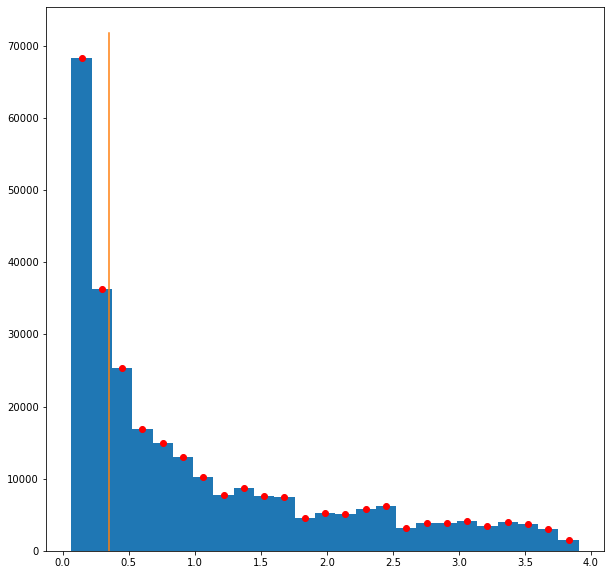

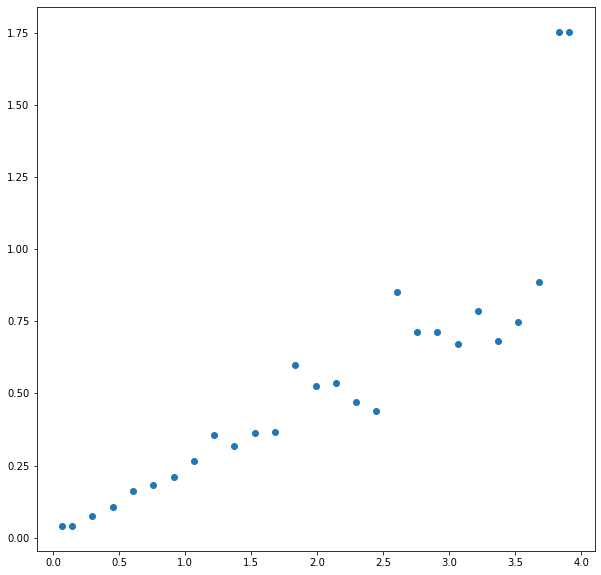

In [10]:
nbins = 25

fig = pyl.figure(figsize=(10,10))
sp = fig.add_subplot(111)
(y, x) = pyl.hist(sns_labels, bins=nbins)[:2]


pyl.plot([0.35, 0.35], sp.get_ylim())

bins = (x[1:]+x[:-1])/2.0


pyl.scatter(bins, y, c='r',zorder=10)
pyl.show()

hist_weights = np.max(y)/(y*nbins)

hist_weights = np.concatenate([np.array([hist_weights[0]]), 
                               hist_weights, 
                               np.array([hist_weights[-1]])])
bins = np.concatenate([np.array([np.min(sns_labels)]), 
                    bins, 
                    np.array([np.max(sns_labels)])])

hist_weights[np.where(np.isinf(hist_weights))] = 0.0


fig = pyl.figure(figsize=(10,10))
pyl.scatter(bins, hist_weights)
pyl.show()

weight_func = interp.interp1d(bins, hist_weights)

sample_weights = weight_func(sns_labels).astype('float32')
mean_sample_weights = np.mean(sample_weights)
sample_weights /= mean_sample_weights

train_weights = sample_weights[train_index]
test_weights = sample_weights[test_index]




# Fitting the Neural Network Model

Here we train the neural network model defined above. The training session will output loss, and accuracy at each epoch. We also plot the progression of the loss and accuracy with respect to training epochs after the training is completed.

In [11]:
backend.clear_session()

gc.collect()

cn_model = convnet_model(X_train.shape[1:], 
                         learning_rate = learning_rate*4,
                         num_dense_nodes = num_dense_nodes,
                         num_dense_layers = num_dense_layers,
                         num_models = num_models, num_filters = num_filters)
                             
cn_model.compile()
cn_model.model_.summary()


start = time.time()

cn_model.train_models(X_train, y_train, sample_weights = train_weights,
                      train_epochs = train_epochs, 
                      batch_size=int(batch_size), 
                      useSampleWeights = useSampleWeights)


end = time.time()
print('Process completed in', round(end-start, 2), ' seconds')



2024-04-18 18:23:05.361370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 18:23:05.374168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 18:23:05.376408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 18:23:05.379878: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 43, 43, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 41, 41, 6)    60          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 21, 21, 6)    0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 19, 19, 6)    330         max_pooling2d_12[0][0]           
____________________________________________________________________________________________

2024-04-18 18:23:44.519403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250


2024-04-18 18:23:57.792846: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2024-04-18 18:24:00.068096: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-18 18:24:01.711546: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


64/64 [==============================] - 22s 44ms/step - loss: 0.9640 - mean_absolute_error: 0.6547
Epoch 2/250
64/64 [==============================] - 2s 37ms/step - loss: -0.6215 - mean_absolute_error: 0.4630
Epoch 3/250
64/64 [==============================] - 2s 36ms/step - loss: -1.2326 - mean_absolute_error: 0.4628
Epoch 4/250
64/64 [==============================] - 2s 34ms/step - loss: -1.5025 - mean_absolute_error: 0.4792
Epoch 5/250
64/64 [==============================] - 2s 34ms/step - loss: -1.6371 - mean_absolute_error: 0.4847
Epoch 6/250
64/64 [==============================] - 2s 34ms/step - loss: -1.7096 - mean_absolute_error: 0.4877
Epoch 7/250
64/64 [==============================] - 2s 34ms/step - loss: -1.7425 - mean_absolute_error: 0.4895
Epoch 8/250
64/64 [==============================] - 2s 34ms/step - loss: -1.7844 - mean_absolute_error: 0.4900
Epoch 9/250
64/64 [==============================] - 2s 34ms/step - loss: -1.8057 - mean_absolute_error: 0.4918
Epoc

# Make some training diagnostic plots

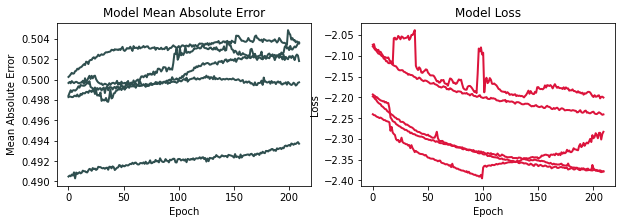

In [12]:
"""
Plot accuracy/loss versus epoch
"""

fig = pyl.figure(figsize=(10,3))

## skip the first n epochs for clarity of the figures
n=40

ax1 = pyl.subplot(121)
for i in range(cn_model.num_models):
    ax1.plot(cn_model.classifiers[i].history['mean_absolute_error'][n:], color='darkslategray', linewidth=2)
ax1.set_title('Model Mean Absolute Error')
ax1.set_ylabel('Mean Absolute Error')
ax1.set_xlabel('Epoch')

ax2 = pyl.subplot(122)
for i in range(cn_model.num_models):
    ax2.plot(cn_model.classifiers[i].history['loss'][n:], color='crimson', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

pyl.show()
pyl.close()


In [13]:
## get predictions for test and training samples

preds_test = cn_model.predict(X_test)
preds_train = cn_model.predict(X_train)


8148/8148 [==============================] - 13s 2ms/step


In [14]:
# Make some diagnostic plots of the network performance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


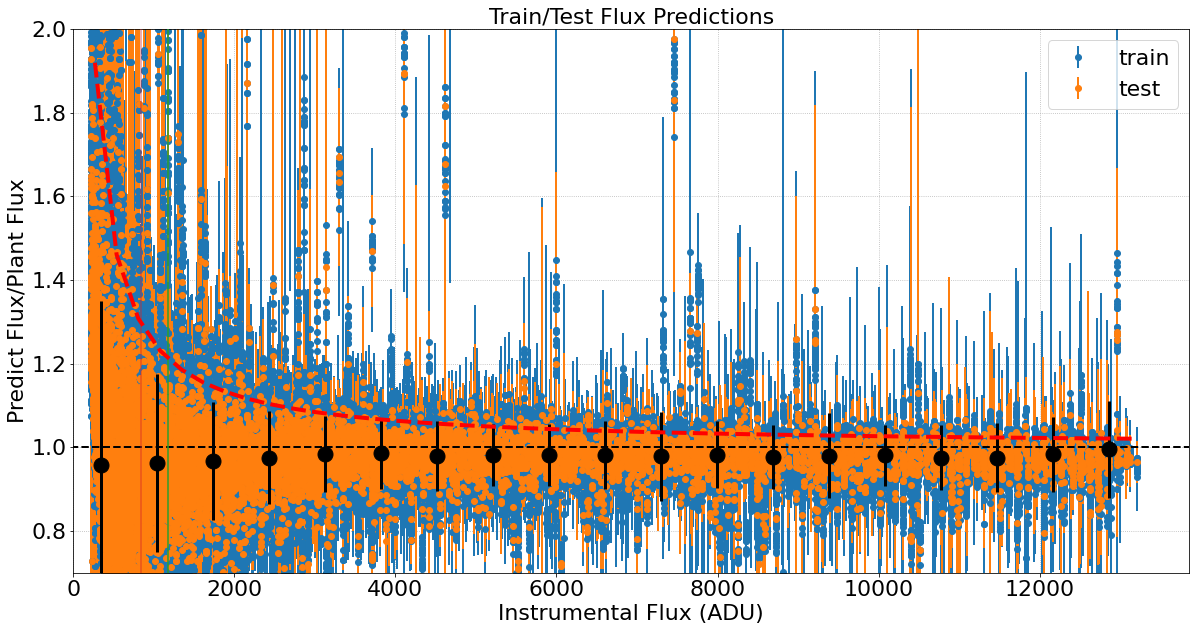

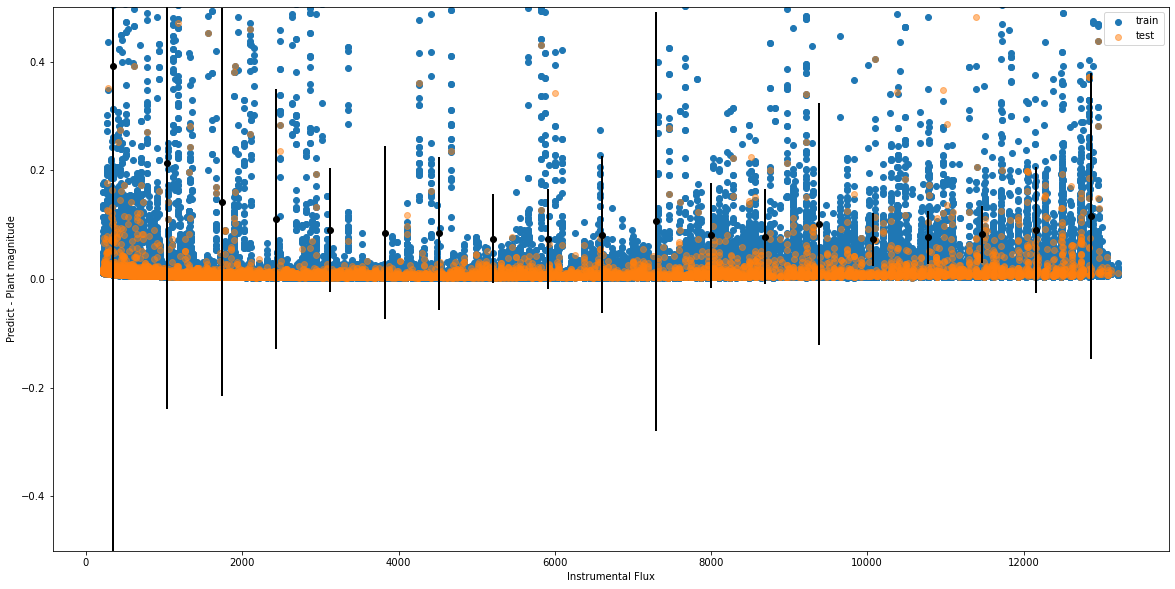

In [15]:

## some diagnostic plots!
flux = preds_test[:,0]*Flux_std

bins = np.linspace(0, max(np.max(y_train), np.max(y_test))*Flux_std, 20)

vals = bins[:-1]*0.0
e_vals = np.zeros((len(bins)-1,2))
for i in range(len(bins)-1):
    w = np.where((flux>bins[i])&(flux<bins[i+1]))
    vals[i] = np.median(flux[w]/y_test[w]/Flux_std)
    
    dm = 1.09*preds_test[w, 1]**0.5/preds_test[w, 0]
    e_vals[i, 0] = np.mean(dm)
    e_vals[i, 1] = np.std(dm)
vals = np.array(vals)
e_vals = np.array(e_vals)


## flux prediction vs. known values
fig = pyl.figure(figsize=(20,10))
sp = fig.add_subplot(111)
sp.set_title('Train/Test Flux Predictions', fontsize=22)

pyl.errorbar(y_train*Flux_std, preds_train[:,0]/y_train,
             yerr = preds_train[:, 1]**0.5/y_train, linestyle = 'none', lw=2, marker='o', label = 'train')
pyl.errorbar(y_test*Flux_std, preds_test[:,0]/y_test,
             yerr = preds_test[:, 1]**0.5/y_test, linestyle = 'none', lw=2, marker='o', label='test')



pyl.errorbar((bins[1:]+bins[:-1])/2.0, vals, yerr=e_vals[:,0], linestyle = 'none', lw=3, ms=15, marker='o',c='k', zorder=11)

xlim = sp.get_xlim()
pyl.plot(xlim, [1,1], 'k--',lw=2,zorder=10)

flux_x = np.linspace(0, bins[-1], 50)
snr_est_y = (flux_x*(flux_x+68*900)**-(0.5)) # estimate bg limited SNR, with bg=1300 ADU, and a radius = 1.4*0.7" aperture, or 90 pix
pyl.plot(flux_x, 1.+(1./snr_est_y), 'r--', lw=4, zorder=12)

sp.set_ylim(0.7, 2.0)
pyl.plot(np.array([0.35,0.35])*Flux_std, sp.get_ylim(), zorder=10)
pyl.plot(np.array([0.25,0.25])*Flux_std, sp.get_ylim(), zorder=10, alpha=0.5)
sp.set_xlim(0, xlim[1])

sp.grid(linestyle=':')
pyl.xlabel('Instrumental Flux (ADU)', fontsize=22)
pyl.ylabel('Predict Flux/Plant Flux', fontsize=22)
pyl.xticks(fontsize=22)
pyl.yticks(fontsize=22)
pyl.legend(fontsize=22)
#pyl.savefig('ChapterFluxRegress.png', bbox_inches='tight')


## predicted-planted instrumental magnitude. Haven't spent as much time refining this figure. 

fig = pyl.figure('2', figsize=(20,10))
sp = fig.add_subplot(111)
pyl.scatter(y_train*Flux_std, 1.09*preds_train[:,1]/preds_train[:, 0], label = 'train')
pyl.scatter(y_test*Flux_std, 1.09*preds_test[:,1]/preds_test[:, 0], label='test', alpha=0.5)
pyl.errorbar((bins[1:]+bins[:-1])/2.0, e_vals[:, 0], yerr = e_vals[:, 1], 
             linestyle = 'none', lw=2, marker='o',c='k')
sp.set_ylim(-0.5, 0.5)
pyl.xlabel('Instrumental Flux')
pyl.ylabel('Predict - Plant magnitude')
pyl.legend()

pyl.show()




In [16]:
if save_model:
    cn_model.saveModel(Flux_std, mean, med, std,
                       save_model_path)
    
    with open(f'{save_model_path}/training_data.pickle', 'bw+') as han:
        pickle.dump([X_train, X_test, y_train, y_test, saved_par_dic], han)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


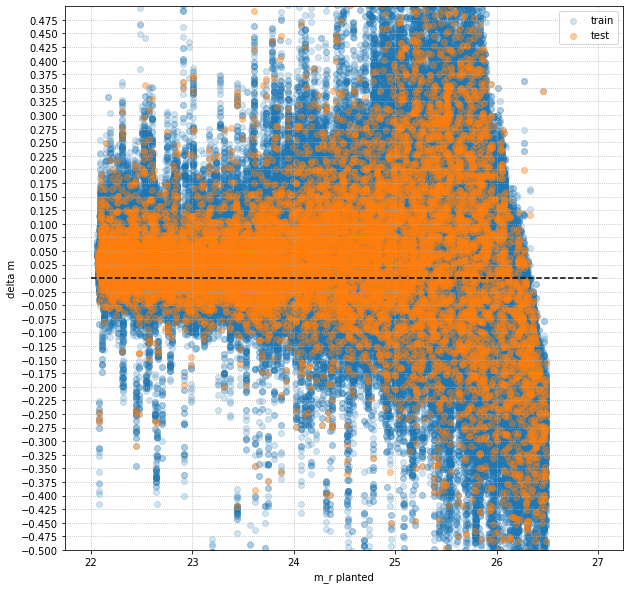

In [17]:


## plot of differences in predicted and planted apparent magnitude 

train_mags = -2.5*np.log10(y_train*Flux_std)
test_mags = -2.5*np.log10(y_test*Flux_std)


pred_train_mags = -2.5*np.log10(preds_train[:, 0]*Flux_std)
pred_test_mags = -2.5*np.log10(preds_test[:, 0]*Flux_std)

w = np.where( ((kb_xys[test_index, -1]+Z_test)>22.5) & ((kb_xys[test_index, -1]+Z_test)<23))


figg = pyl.figure(figsize=(10, 10))
sp = figg.add_subplot(111)

pyl.scatter((kb_xys[train_index, -1]+Z_train), (pred_train_mags-kb_xys[train_index, -1]), alpha=0.2, label='train')
pyl.scatter(kb_xys[test_index, -1]+Z_test, pred_test_mags-kb_xys[test_index, -1], alpha=0.4, label='test')

pyl.legend()

pyl.plot([22,27], [0,0], 'k--', zorder=10)
pyl.xlabel('m_r planted')
pyl.ylabel('delta m')
sp.set_ylim(-0.5,0.5)
sp.set_yticks(np.arange(-0.5,0.5,0.025))

pyl.grid(linestyle=':')

# Now read in validate visit 2022-08-24-AS1 and see how well the machine does



2022-08-24-AS1 00 (61, 43, 43)
2022-08-24-AS1 01 (50, 43, 43)
2022-08-24-AS1 02 (54, 43, 43)
2022-08-24-AS1 03 (62, 43, 43)
2022-08-24-AS1 04 (50, 43, 43)
2022-08-24-AS1 05 (69, 43, 43)
2022-08-24-AS1 06 (63, 43, 43)
2022-08-24-AS1 07 (60, 43, 43)
2022-08-24-AS1 08 (60, 43, 43)
2022-08-24-AS1 09 (57, 43, 43)
2022-08-24-AS1 10 (55, 43, 43)
2022-08-24-AS1 11 (52, 43, 43)
2022-08-24-AS1 12 (68, 43, 43)
2022-08-24-AS1 13 (52, 43, 43)
2022-08-24-AS1 14 (68, 43, 43)
2022-08-24-AS1 15 (60, 43, 43)
2022-08-24-AS1 16 (62, 43, 43)
2022-08-24-AS1 17 (64, 43, 43)
2022-08-24-AS1 18 (56, 43, 43)
2022-08-24-AS1 19 (52, 43, 43)
2022-08-24-AS1 20 (60, 43, 43)
2022-08-24-AS1 21 (59, 43, 43)
2022-08-24-AS1 22 (55, 43, 43)
2022-08-24-AS1 23 (57, 43, 43)
2022-08-24-AS1 24 (50, 43, 43)
2022-08-24-AS1 25 (63, 43, 43)
2022-08-24-AS1 26 (55, 43, 43)
2022-08-24-AS1 27 (58, 43, 43)
2022-08-24-AS1 28 (56, 43, 43)
2022-08-24-AS1 29 (58, 43, 43)
2022-08-24-AS1 30 (59, 43, 43)
2022-08-24-AS1 31 (52, 43, 43)
2022-08-

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in true_divide


(array([0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

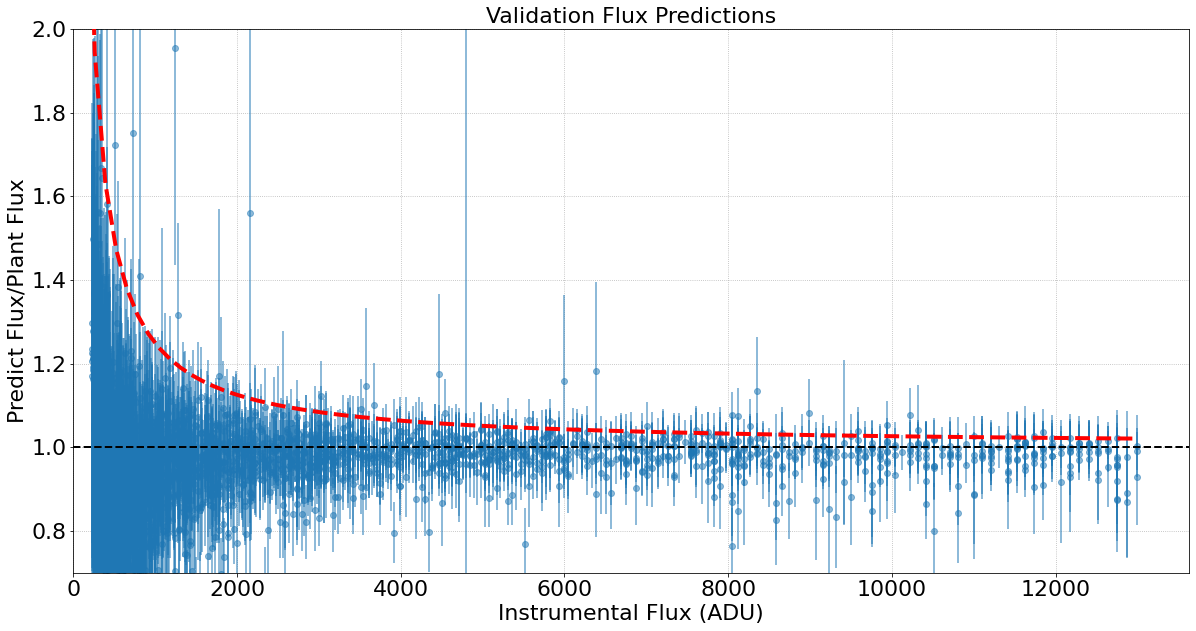

In [18]:
visits_validate = ['2022-08-24-AS1']

chips = []
for c in np.arange(0, 40):#
    chips.append(str(c).zfill(2))

stamp_files_validate, fs_validate, kb_xys_validate, zeropoints_validate = [], [], [], []
counter = 0
for j, v in enumerate(visits_validate):
    for i, c in enumerate(chips):
        
        stamps_path = f'{warps_path}/{v}'
        plantLists_path = f'{warps_path}/{v}/'
        kbmod_results_path = f'./kbmod_results/{v}/results_{c}/'

        stamp_files_validate.append(f'{stamps_path}/stamps{gridType}_{c}_w_sr.pickle')

        zpo = zpos[v][c]
                    
        ### load the kbmod results
        kb_xy = []
        with open(f'{kbmod_results_path}/results_.txt') as han:
            data = han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        plantLists = glob.glob(f'{plantLists_path}/{c}/*plantList')
        plantLists.sort()

        with open(plantLists[0]) as han:
            data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            x,y = float(s[3]), float(s[4])
            rate = float(s[5])*24./0.187
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), rate, 0])
                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where((p_xy[:,2]>nukeBright)&(p_xy[:,2]<nukeFaint))]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                d_rate = (p_xy[ii, 3] - (kb_xy[:, 2]**2 + kb_xy[:, 3]**2)**0.5)
                ww = np.where((d<dist_lim)&(np.abs(d_rate)<rate_diff_lim))
                if len(ww[0])>0:
                    for arg in ww[0]:
                        kb_xy[arg,-1] = p_xy[ii,2]-zpo
                        
        w_good = np.where(kb_xy[:,-1]!=0)
        
        #load the stamps
        with open(stamp_files_validate[-1], 'rb') as han:
            f = pickle.load(han)
        
        if rots[counter%len(chips)]!=0:# and rots[counter%len(chips)]!=2:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))
        counter+=1

        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))
        f_med = np.nanmedian(f)
        f = f[w_good]
        kb_xy = kb_xy[w_good]

        
        fs_validate.append(f)
        kb_xys_validate.append(kb_xy)
        zeropoints_validate.append(np.zeros(len(f), dtype='float64')+zpo)
        print(v, c,f.shape)

sns_frames_validate = np.concatenate(fs_validate)
kb_xys_validate = np.concatenate(kb_xys_validate)
zeropoints_validate = np.concatenate(zeropoints_validate)

del fs_validate

sns_frames_validate = sns_frames_validate.astype(image_data_type)

sns_labels_validate = 10.0**(-0.4*kb_xys_validate[:, -1])


sns_labels_validate = sns_labels_validate/Flux_std

normed_sns_frames_validate = sns_frames_validate
mean_validate,std_validate = np.nanmean(normed_sns_frames_validate), np.nanstd(normed_sns_frames_validate)
normed_sns_frames_validate -= mean_validate
normed_sns_frames_validate /= std
print('Normalized frame min and max:', np.nanmin(normed_sns_frames_validate), np.nanmax(normed_sns_frames_validate),'\n')
print(std,std_validate)


normed_sns_frames_validate = np.expand_dims(normed_sns_frames_validate, axis=-1)

preds_validate = cn_model.predict(normed_sns_frames_validate)
print(preds_validate)

fig = pyl.figure(figsize=(20,10))
sp = fig.add_subplot(111)
pyl.errorbar(sns_labels_validate*Flux_std, preds_validate[:, 0]/sns_labels_validate,
             yerr = preds_validate[:, 1]**0.5/(sns_labels_validate), 
             linestyle = 'none', lw=2, marker='o', label = 'validate', alpha=0.5)

flux_x = np.linspace(0, np.max(sns_labels_validate*Flux_std), 100)
snr_est_y = (flux_x*(flux_x+68*900)**-(0.5)) # estimate bg limited SNR, with bg=1300 ADU, and a radius = 1.4*0.7" aperture, or 90 pix
pyl.plot(flux_x, 1.+(1./snr_est_y), 'r--', lw=4, zorder=12)

pyl.grid(linestyle=':')
xlim = sp.get_xlim()
pyl.plot([0,xlim[1]], [1., 1.], 'k--', lw=2, zorder=10)
sp.set_xlim(0.0, xlim[1])
sp.set_ylim(0.7, 2.0)
pyl.xlabel('Instrumental Flux (ADU)', fontsize=22)
pyl.ylabel('Predict Flux/Plant Flux', fontsize=22)
pyl.title('Validation Flux Predictions', fontsize=22)
pyl.xticks(fontsize=22)
pyl.yticks(fontsize=22)
#pyl.savefig('ChapterRegressValidate.pdf', bbox_inches='tight')


